# Importing Modules and Libraries

In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img,img_to_array
from tensorflow.keras.losses import CategoricalCrossentropy
from PIL import Image
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau,ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Accuracy,F1Score,Precision,Recall
from tensorflow.keras.layers import Conv2D,Input,MaxPool2D,AvgPool2D,GlobalAvgPool2D,GlobalMaxPool2D,Dense,BatchNormalization,Flatten,Dropout,GlobalAveragePooling2D
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model

# Plotting Images to understand details

In [2]:
path="/kaggle/input/cat-and-dog/test_set/test_set/cats"
sample_files=[os.path.join(path,i) for i in os.listdir(path)]

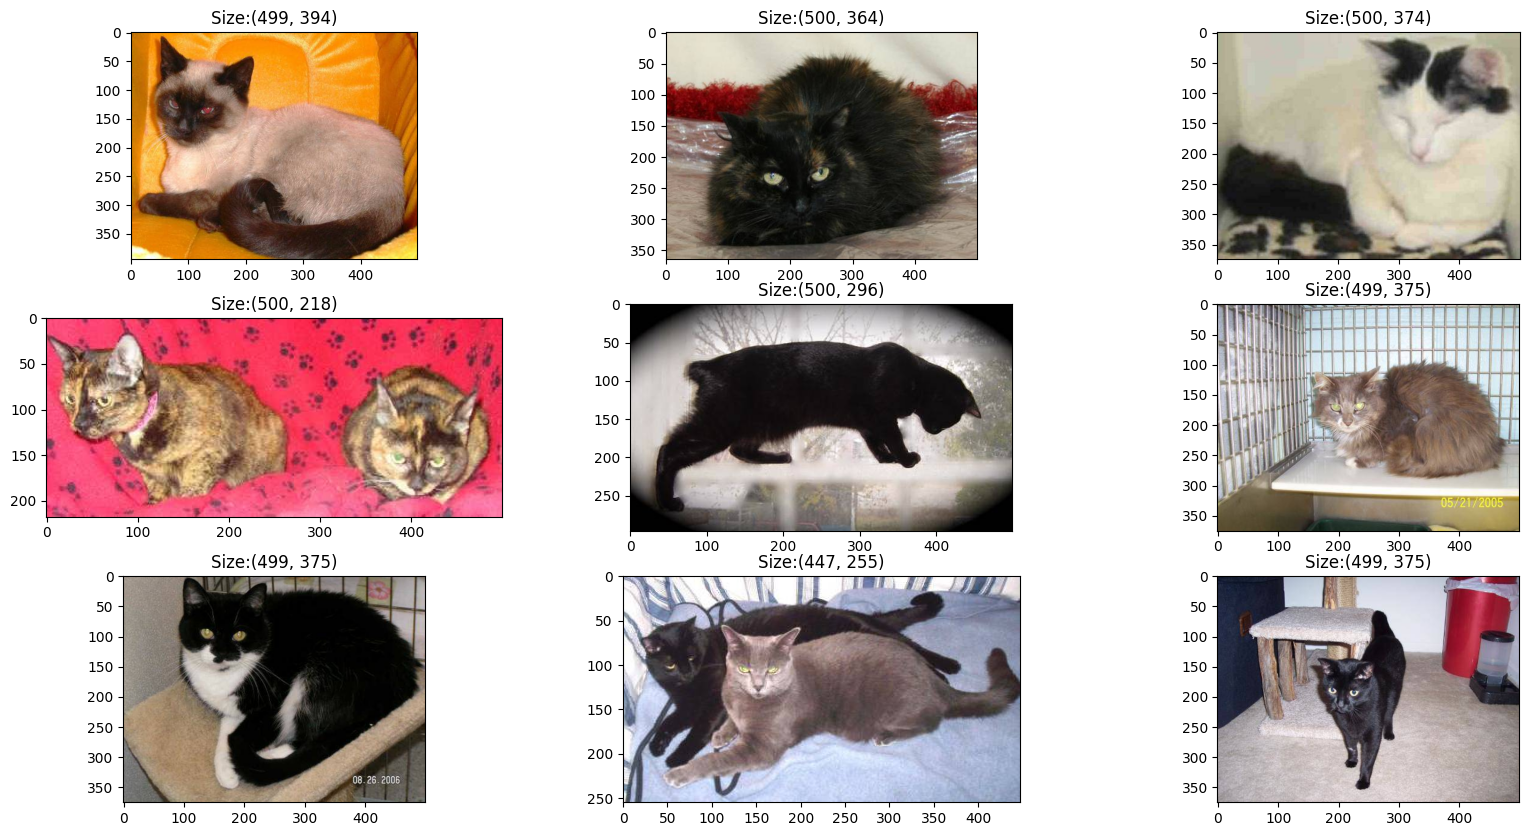

In [3]:
fig,axis=plt.subplots(3,3,figsize=(20,10))
axis=axis.flatten()
count=0
rand_indices=np.random.randint(0,len(sample_files),size=(9,1)).flatten()
for i in range(len(rand_indices)):
    image=load_img(sample_files[rand_indices[i]])
    axis[count].imshow(image)
    axis[count].set_title("Size:"+str(image.size))
    count+=1

> Image Size is (300,300)

# Configurations

In [4]:
CONFIG={
    "BATCH_SIZE":16,
    "IMG_SIZE":(300,300),
    "STRIDE_1":1,
    "STRIDE_2":2,
    "REGUL":0.001,
    "DROP_OUT":0.2,
    "DENSE_L1":1024,
    "DENSE_L2":512,
    "DENSE_L3":256,
    "DENSE_L4":128,
    "KERNEL_SIZE_3":(3,3),
    "KERNEL_SIZE_2":(5,5),
    "KERNEL_SIZE_1":(7,7),
    "LR":0.001,
    "POOL_SIZE":(2,2),
    "train_path":"/kaggle/input/cat-and-dog/training_set/training_set",
    "FILTERS":32
    
}

# Generators

In [5]:
train_img_gen=ImageDataGenerator(rescale=1/255.0,validation_split=0.2)


In [6]:
train_gen=train_img_gen.flow_from_directory(directory=CONFIG["train_path"],target_size=CONFIG["IMG_SIZE"],batch_size=CONFIG['BATCH_SIZE'],shuffle=True,class_mode='binary',color_mode='rgb',subset='training')

Found 6404 images belonging to 2 classes.


In [7]:
val_gen=train_img_gen.flow_from_directory(directory=CONFIG["train_path"],target_size=CONFIG["IMG_SIZE"],batch_size=CONFIG['BATCH_SIZE'],shuffle=True,class_mode='binary',color_mode='rgb',subset='validation')

Found 1601 images belonging to 2 classes.


# Generator Image Plotting

In [8]:
x,y=next(train_gen)

In [9]:
# Plotting Generator Images

In [10]:
images=x
labels=list(np.array(y,dtype=int))

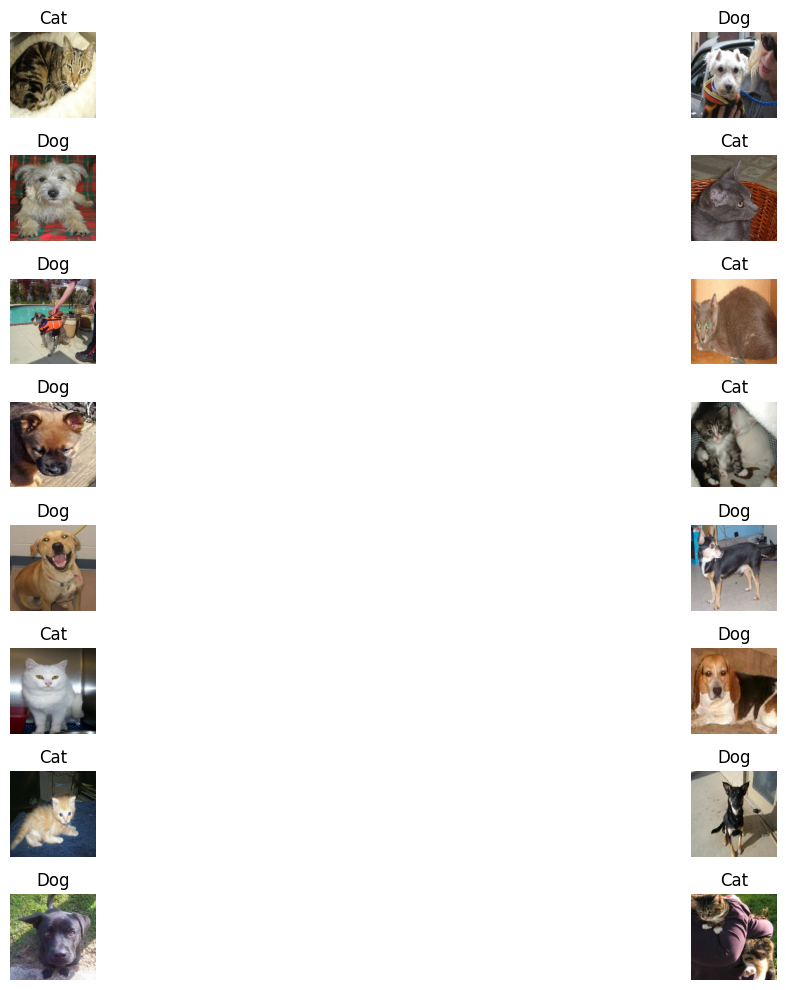

In [11]:
fig,axis=plt.subplots(8,2,figsize=(20,10))
axis=axis.flatten()
count=0
for i in range(len(labels)):

    axis[count].imshow(images[i],cmap='gray')
    title=['Cat',"Dog"][labels[i]]
    axis[count].set_title(title)
    axis[count].axis('off')
    count+=1
    
plt.tight_layout()


# Modelling

In [12]:
def get_model(input_shape=(300,300,3),no_of_labels=1):
    tf.keras.backend.clear_session()
    i=Input(shape=input_shape)
    #First
    x=Conv2D(filters=32,kernel_size=3,activation='relu',strides=CONFIG['STRIDE_1'],padding='valid')(i)
    x=BatchNormalization()(x)
    x=MaxPool2D(pool_size=CONFIG['POOL_SIZE'],strides=CONFIG['STRIDE_2'])(x)
    
    #Second
    x=Conv2D(filters=32,kernel_size=3,activation='relu',strides=CONFIG['STRIDE_1'],padding='valid')(x)
    x=BatchNormalization()(x)
    x=MaxPool2D(pool_size=CONFIG['POOL_SIZE'],strides=CONFIG['STRIDE_2'])(x)
    
    #Third
    x=Conv2D(filters=64,kernel_size=3,activation='relu',strides=CONFIG['STRIDE_1'],padding='valid')(x)
    x=MaxPool2D(pool_size=CONFIG['POOL_SIZE'],strides=CONFIG['STRIDE_2'])(x)
    x=BatchNormalization()(x)
    
    x=Flatten()(x)
    
    x=Dense(units=1024,activation='relu')(x)
    
    x=Dense(units=256,activation='relu')(x)
    
    
    x=Dense(no_of_labels,activation='sigmoid',name='last_layer')(x)
    
    return Model(i,x)
    
    

In [13]:
model=get_model()

In [14]:
import gc
import tensorflow as tf

# Clear session
tf.keras.backend.clear_session()

# Manually clear variables
gc.collect()


0

In [15]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 300, 300, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 298, 298, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 298, 298, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 149, 149, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 147, 147, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 147, 147, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 73, 73, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 71, 71, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 35, 35, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 35, 35, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 78400)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │    80,282,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       262,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ last_layer (Dense)              │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 80,574,433 (307.37 MB)

 Trainable params: 80,574,177 (307.37 MB)

 Non-trainable params: 256 (1.00 KB)

# Compiling Model

In [16]:
model.compile(loss='binary_crossentropy',metrics=['accuracy'],optimizer=Adam(learning_rate=CONFIG['LR']))

In [17]:
steps_per_epoch=len(train_gen)
validation_steps=len(val_gen)


# Callbacks

In [18]:
callbacks=[EarlyStopping(monitor='val_accuracy',mode='max',verbose=1,patience=30),
           ReduceLROnPlateau(monitor='val_loss',mode='min',patience=10,verbose=1),
           ModelCheckpoint(filepath='/kaggle/working/checked_model.keras',monitor='val_accuracy',mode='max',save_best_only=True,save_freq='epoch')]

In [19]:
# output_signature=(tf.TensorSpec(shape=(None,300,300,3),dtype=tf.float32),tf.TensorSpec(shape=(None,1),dtype=tf.float32))

In [20]:
# def gen_t():
#     for x,y in train_gen:
#         yield x,y
        
# def gen_v():
#     for x,y in val_gen:
#         yield x,y


In [21]:
# train_gen=tf.data.Dataset.from_generator(gen_t,output_signature=output_signature)
# val_gen=tf.data.Dataset.from_generator(gen_v,output_signature=output_signature)

# Model Fitting

In [22]:
model.fit(train_gen,batch_size=CONFIG['BATCH_SIZE'],epochs=100,validation_data=val_gen,callbacks=callbacks,steps_per_epoch=6404//32,validation_steps=1601//32)

Epoch 1/100


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1726743383.375435      79 service.cc:145] XLA service 0x78fb240068a0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1726743383.375526      79 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0


  3/200 ━━━━━━━━━━━━━━━━━━━━ 11s 59ms/step - accuracy: 0.5521 - loss: 6.3132

I0000 00:00:1726743388.569373      79 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


200/200 ━━━━━━━━━━━━━━━━━━━━ 34s 126ms/step - accuracy: 0.5423 - loss: 5.9403 - val_accuracy: 0.5537 - val_loss: 0.7051 - learning_rate: 0.0010
Epoch 2/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 22s 112ms/step - accuracy: 0.6637 - loss: 0.6251 - val_accuracy: 0.6000 - val_loss: 0.6941 - learning_rate: 0.0010
Epoch 3/100
  1/200 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - accuracy: 0.6250 - loss: 0.7158

/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6250 - loss: 0.7158 - val_accuracy: 0.0000e+00 - val_loss: 1.7423 - learning_rate: 0.0010
Epoch 4/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 18s 90ms/step - accuracy: 0.7304 - loss: 0.5413 - val_accuracy: 0.6575 - val_loss: 0.6654 - learning_rate: 0.0010
Epoch 5/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 16s 79ms/step - accuracy: 0.7791 - loss: 0.4704 - val_accuracy: 0.7225 - val_loss: 0.5781 - learning_rate: 0.0010
Epoch 6/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 0.7500 - loss: 0.4145 - val_accuracy: 1.0000 - val_loss: 0.1046 - learning_rate: 0.0010
Epoch 7/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 13s 63ms/step - accuracy: 0.8067 - loss: 0.4268 - val_accuracy: 0.6800 - val_loss: 0.6285 - learning_rate: 0.0010
Epoch 8/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 12s 58ms/step - accuracy: 0.8403 - loss: 0.3635 - val_accuracy: 0.6988 - val_loss: 0.6400 - learning_rate: 0.0010
Epoch 9/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 96us/step - accuracy: 0.5625 - loss: 

# Training Results

In [23]:
history=model.history.history

In [24]:
import seaborn as sb
def history_plot(history,key_word):
    epochs=len(history[key_word])
    sub_key_word='val_'+key_word
    sb.lineplot(x=range(epochs),y=history[key_word],label=key_word)
    sb.lineplot(x=range(epochs),y=history[sub_key_word],label=sub_key_word)
    plt.legend()
    plt.show()

In [25]:
from tensorflow.keras.models import load_model

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

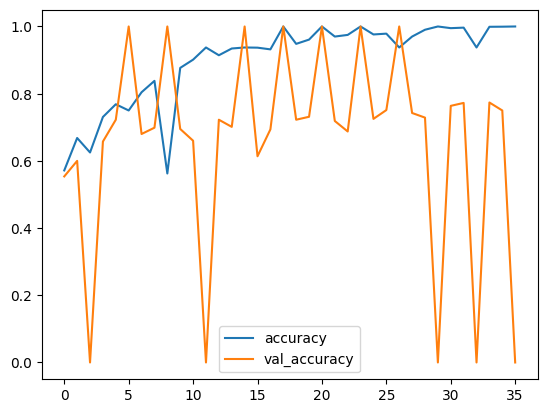

In [26]:
history_plot(history,'accuracy')

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

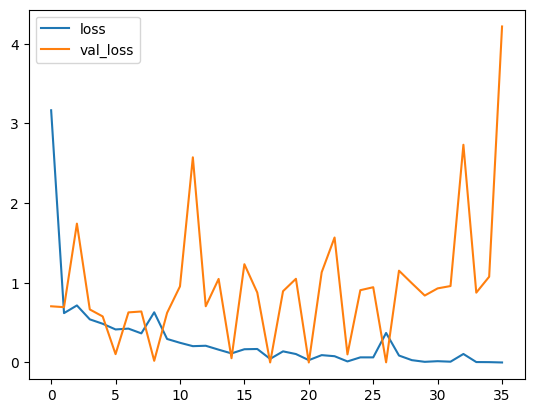

In [27]:
history_plot(history,'loss')